In [11]:
import re as re

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering


import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
%ls data

Air pollutant.csv  Energy.csv         GWP.csv            sector.csv


In [13]:
airpolu=pd.read_csv("data/Air pollutant.csv")
energy=pd.read_csv("data/Energy.csv")
GWP=pd.read_csv("data/GWP.csv")
sector=pd.read_csv("data/sector.csv")

In [14]:
def combineSector(df, df_sector):
    def find_number(text):
        num = re.findall(r'[0-9]+',text)
        return " ".join(num)

    def first2(text):
        return text[:2]
    df2 = df.copy()
    ID2 = df2['ID'].map(find_number).map(first2).astype('int64')
    df2.insert(loc=1, column='ID2', value=ID2)
    df_sector=df_sector.merge(df2, on='ID2', how='right')
    return df_sector

def tsneFind2Pinciple(df_sector):

    Principle = TSNE(n_components=2).fit_transform(df_sector.iloc[:,4:])
    Principle=pd.DataFrame(Principle, columns=['P1','P2'])
    new_df=df_sector.iloc[:,:4]
    new_df[['P1','P2']]=Principle
    return new_df

def addCluster(df_sector, df_principle):

    clustering = SpectralClustering(n_clusters=3, assign_labels='discretize',random_state=0).fit(df_principle[['P1','P2']])
    df_principle['cluster']=clustering.labels_
    return df_principle

def plot(df_sector_cluster):
    plt.figure(figsize=(10,10))
    g= sns.scatterplot(data=df_sector_cluster, x="P1", y="P2", style="cluster", hue="cluster", palette="deep")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    
def checkGroupAgg(df, df_sector_cluster, by=['cluster','Sector'], func = ['max','min']):
    df_cluster = pd.concat([df_sector_cluster[by], df.iloc[:,2:]], axis=1)
    return df_cluster.groupby(by).agg(func).style.highlight_max(axis=0)

def groupcount(df_sector_cluster):
    df = df_sector_cluster[['cluster','Sector','ID']].groupby(['cluster','Sector']).agg('count').reset_index(drop=False)
    df.columns=['cluster','Sector','count']
    return df.sort_values(by=['cluster','count'], ascending=False)


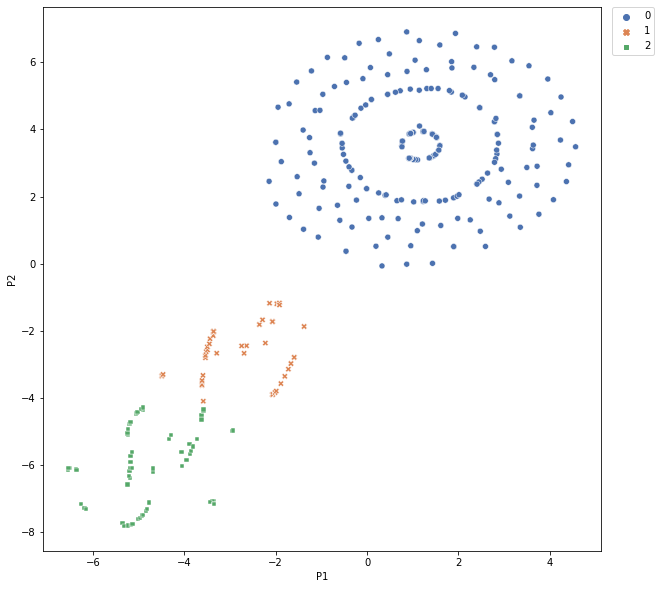

In [15]:
sector = combineSector(energy, df_sector=sector)
principle = tsneFind2Pinciple(sector)
sector_cluster= addCluster(df_sector=sector, df_principle=principle)
plot(sector_cluster)

In [16]:
checkGroupAgg(df = energy, df_sector_cluster = sector_cluster,
             by=['cluster'], func = ['max','min'])

In [17]:
checkGroupAgg(df = energy, df_sector_cluster = sector_cluster,
             by=['cluster','Sector'], func = ['max','min'])

In [18]:
groupcount(sector_cluster)

,cluster,Sector,count
31,2,Manufacturing,43
32,2,"Mining, Quarrying, and Oil and Gas Extraction",5
35,2,Transportation and Warehousing,5
34,2,Real Estate and Rental and Leasing,3
36,2,Utilities,3
24,2,Administrative and Support and Waste Managemen...,2
25,2,"Agriculture, Forestry, Fishing and Hunting",2
26,2,"Arts, Entertainment, and Recreation",1
27,2,Educational Services,1
28,2,Finance and Insurance,1
